<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required libraries

In [75]:
# Define the target FX symbol: 
data = '/content/drive/MyDrive/data/EURUSD_M30.csv'
volumeAdjFactor = 1
symbol = 'EURUSD'
dropUnamed = True # if the dataset contains unamed column

In [76]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import warnings
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

# Data Extraction

In [77]:
#read data
df = pd.read_csv(data, parse_dates=True)
# #setting index as date because some statsmodels might not work
df.index = pd.to_datetime(df['Date'])
# Normalize volumes 
df['Volume'] = df['Volume']/volumeAdjFactor
df = df[df.index.dayofweek < 5]
# drop unamed 
if dropUnamed:
  df.drop('Unnamed: 0', axis=1, inplace=True)
print(len(df))

257600


# Add RSI, MACD, CCI indicators to df

In [78]:
# constants
period = 14
data_window = 1000
macd_slow = 26
macd_fast = 12
macd_smooth = 9
cci_ct = 0.015 #CCI = (AveP - SMA_of_AveP) / (0.015 * Mean Deviation)
cci_period = 20
rsi_period = period

def get_macd(df, slow, fast, smooth):
    
    exp1_8 = df['Close'].ewm(span = fast*8, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow*8, adjust = False).mean()
    
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth*period, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_cci(df, n, constant): 
    TP = (df['High'] + df['Low'] + df['Close']) / 3 
    #moving_avg = ts_log.rolling(12).mean()
    CCI = (pd.Series((TP - TP.rolling(n).mean()) / (constant * TP.rolling(n).std()), name = 'CCI_' + str(n))).dropna()   
    return CCI

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

def get_adx(df: pd.DataFrame(), interval):
    df['-DM'] = df['Low'].shift(1) - df['Low']
    df['+DM'] = df['High'] - df['High'].shift(1)
    df['+DM'] = np.where((df['+DM'] > df['-DM']) & (df['+DM']>0), df['+DM'], 0.0)
    df['-DM'] = np.where((df['-DM'] > df['+DM']) & (df['-DM']>0), df['-DM'], 0.0)
    df['TR_TMP1'] = df['High'] - df['Low']
    df['TR_TMP2'] = np.abs(df['High'] - df['Close'].shift(1))
    df['TR_TMP3'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)
    df['TR'+str(interval)] = df['TR'].rolling(interval).sum()
    df['+DMI'+str(interval)] = df['+DM'].rolling(interval).sum()
    df['-DMI'+str(interval)] = df['-DM'].rolling(interval).sum()
    df['+DI'+str(interval)] = df['+DMI'+str(interval)] /   df['TR'+str(interval)]*100
    df['-DI'+str(interval)] = df['-DMI'+str(interval)] / df['TR'+str(interval)]*100
    df['DI'+str(interval)+'-'] = abs(df['+DI'+str(interval)] - df['-DI'+str(interval)])
    df['DI'+str(interval)] = df['+DI'+str(interval)] + df['-DI'+str(interval)]
    df['DX'] = (df['DI'+str(interval)+'-'] / df['DI'+str(interval)])*100
    df['ADX'+str(interval)] = df['DX'].rolling(interval).mean()
    df['ADX'+str(interval)] =   df['ADX'+str(interval)].fillna(df['ADX'+str(interval)].mean())
    del df['TR_TMP1'], df['TR_TMP2'], df['TR_TMP3'], df['TR'], df['TR'+str(interval)]
    del df['+DMI'+str(interval)], df['DI'+str(interval)+'-']
    del df['DI'+str(interval)], df['-DMI'+str(interval)]
    del df['+DI'+str(interval)], df['-DI'+str(interval)]
    del df['DX']
    return df

In [79]:
df = get_macd(df, macd_slow, macd_fast, macd_smooth)
df = get_adx (df, period*4)
df['cci'] = get_cci(df, cci_period, cci_ct)
df['rsi'] = get_rsi(df, rsi_period)

In [80]:
# Plot MACD
def plot_macd(prices, df):
    ax_price = plt.subplot2grid((6,1), (0,0),  colspan = 1)
    ax_macd8 = plt.subplot2grid((6,1), (2,0), colspan = 1)
    ax_cci = plt.subplot2grid((6,1), (3,0), colspan = 1)
    ax_rsi = plt.subplot2grid((6,1), (4,0), colspan = 1)
    ax_volume = plt.subplot2grid((6,1), (5,0), colspan = 1)
    # plot the prices
    ax_price.plot(prices)
    # plot the indicators
    ax_macd8.plot(df['macd8'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax_macd8.plot(df['signal8'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax_cci.plot(df['cci'], color = 'orange', linewidth = 1.5, label = 'CCI')
    ax_rsi.plot(df['rsi'], color = 'green', linewidth = 1.5, label = 'RSI')
    ax_volume.bar(prices.index, df['Volume'], color = 'grey', label = 'VOLUME')

    for i in range(len(prices)):
        if str(df['hist8'][i])[0] == '-':
            ax_macd8.bar(prices.index[i], df['hist8'][i], color = '#ef5350')
        else:
            ax_macd8.bar(prices.index[i], df['hist8'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

# Calculate max profit on each point and determine potential entry points



## Training and Validation Datasets

In [81]:
# Standard Deviation 
df['Change'] = (df['Close']-df['Close'].shift(-1))/df['Close'].shift(-1)
risk = df['Change'].std(skipna=True)
df.drop('Change', axis = 1, inplace=True)
risk_factor = 4
target_rate = risk*risk_factor
target_rate

0.0035838529128128377

In [82]:
# Profit:Risk ratio : 2:1
max_duration = 8 # in periods or laggs (for example 30min* 8 = 240min = 4 hours)
# get prices
highest_prices = df['Close']
lowest_prices = df['Close']
# calculte rolling min and max prices (after the possible entrypoints)
# the goal is ONLY to filter entrypoints before building the model
df['max_price'] = (((highest_prices.rolling(max_duration).max().shift(-max_duration)) - df['Close']) / df['Close'])
df['min_price'] = (((lowest_prices.rolling(max_duration).min().shift(-max_duration)) - df['Close']) / df['Close'])
# drop the last (max_duration) rows
df = df[:-max_duration]
# generate signals for the training dataset
df['tsignal'] = df.apply(lambda row: 1 if row['max_price'] >= target_rate else 0, axis =1)
df['atsignal'] = df.apply(lambda row: -1 if row['min_price'] <= -target_rate else 0, axis =1)
df['tsignal'].loc[df.tsignal==0] = df.loc[df.tsignal==0]['atsignal']
# drop nans after replacing infinity
df['Volume'].replace(0, np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [83]:
# filter weak signals (insuffisant volume)
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

average_trade_volume = reject_outliers(df.loc[(df.tsignal == 1) | (df.tsignal == -1)].Volume, m=6).mean()
df['tsignal'].loc[df.Volume<average_trade_volume] = 0
average_trade_volume

1452.1740574655373

# Transform dates to features

In [84]:
import datetime
from dateutil import parser
df['Date'] = pd.to_datetime(df['Date'])
df['moment'] = df['Date'].dt.dayofweek * 10000  + df['Date'].dt.hour * 60 + df['Date'].dt.minute

#Implement Decision Tree Model

In [85]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
feature_names = list(df.columns)
non_features = ['Date', 'tsignal', 'Close', 'min_price', 'max_price', 'Open', 'High', 'Low', 'atsignal', 'moment', 'cci']
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['Volume', 'macd8', 'signal8', 'hist8', '-DM', '+DM', 'ADX56', 'rsi']


In [87]:
# train the model
X = df[feature_names]
y = df['tsignal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

rfc = RandomForestClassifier(random_state=0)
rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('Model accuracy', accuracy_score(y_test, y_pred, normalize=True))
print(report)

Model accuracy 0.9520266073092453
              precision    recall  f1-score   support

          -1       0.70      0.08      0.14      1961
           0       0.95      1.00      0.98     73353
           1       0.75      0.07      0.13      1958

    accuracy                           0.95     77272
   macro avg       0.80      0.38      0.42     77272
weighted avg       0.94      0.95      0.93     77272



In [88]:
from joblib import dump, load
dump(rfc, '/content/drive/MyDrive/data/{symbol}.joblib'.format(symbol=symbol)) 

['/content/drive/MyDrive/data/EURUSD.joblib']

## Model feature importance
The mean decrease in Gini coefficient is a measure of how each variable contributes to the homogeneity of the nodes and leaves in the resulting random forest. The higher the value of mean decrease accuracy or mean decrease Gini score, the higher the importance of the variable in the model.

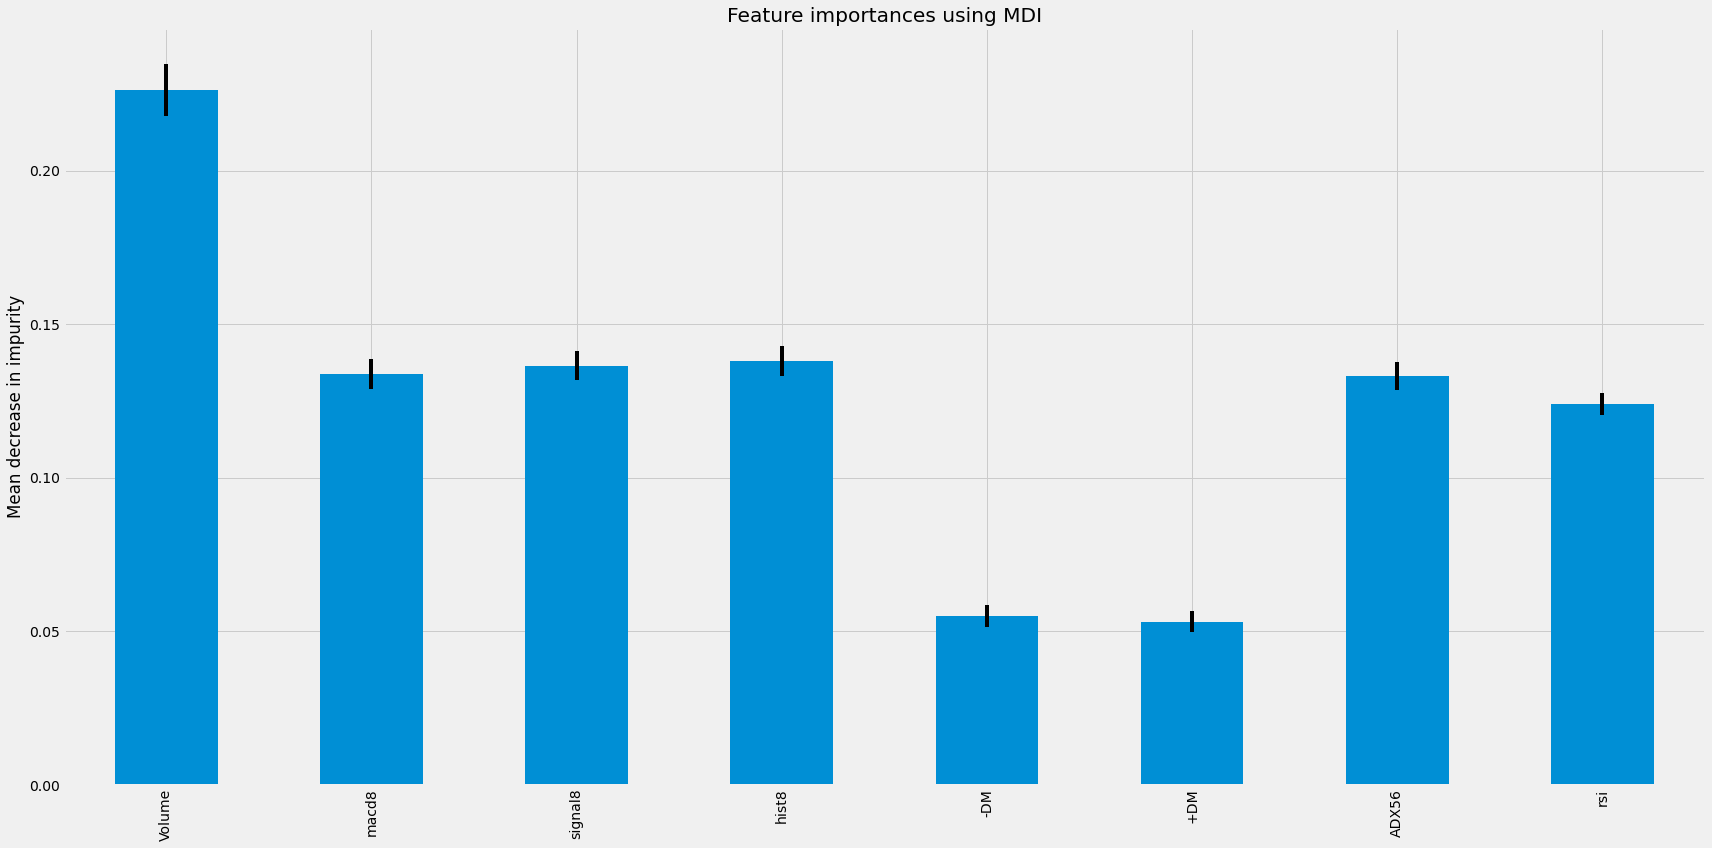

In [89]:
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#Plot the signals

In [90]:
ddf = df.drop(non_features, axis=1)
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['Close'] = df['Close']
# reduce data
ddf = ddf[-2000:]
ddf.loc[ddf.predicted_signal == 1].tail()

,Volume,macd8,signal8,hist8,-DM,+DM,ADX56,rsi,predicted_signal,Close
Date,,,,,,,,,,
2019-10-17 09:30:00,1614.0,0.001659,0.001196,0.000463,0.00026,0.00000,20.135796,42.828492,1,1.10668
2019-10-17 10:00:00,2599.0,0.001675,0.001203,0.000471,0.00000,0.00000,20.502628,60.472070,1,1.10803
2019-10-17 10:30:00,3226.0,0.001687,0.001211,0.000476,0.00000,0.00111,20.933002,56.834249,1,1.10777
2019-10-17 11:00:00,3005.0,0.001694,0.001219,0.000475,0.00076,0.00000,21.244598,52.275321,1,1.10742
2019-11-29 15:00:00,2535.0,-0.000705,-0.000876,0.000171,0.00038,0.00000,10.962943,18.189218,1,1.09862


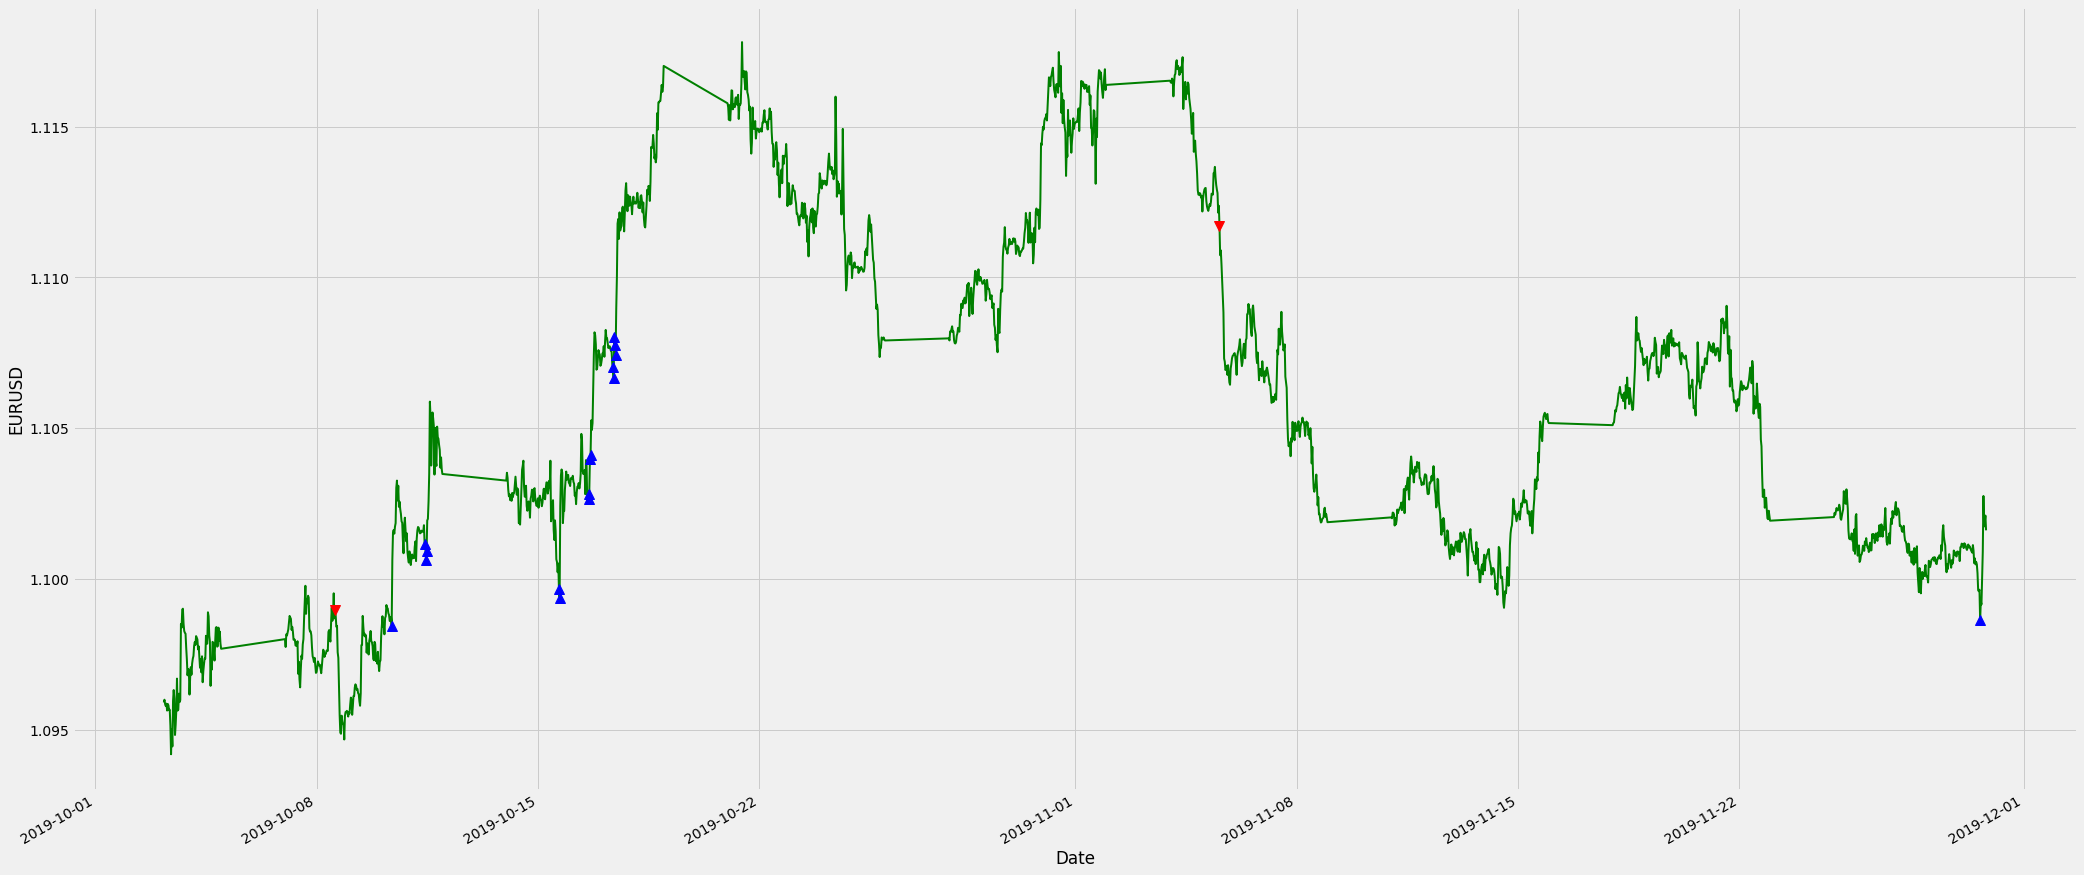

In [91]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel=symbol)

## Plot the closing price
ddf['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(ddf.loc[ddf.predicted_signal == 1.0].index, 
         ddf.Close[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
ax1.plot(ddf.loc[ddf.predicted_signal == -1.0].index, 
         ddf.Close[ddf.predicted_signal == -1.0],
         'v', markersize=10, color='r')
# Show the plot
plt.show()

# Simple Backtest

                     EURUSD  holdings   cash  total  returns
Date                                                        
2019-11-29 17:30:00     0.0       0.0  225.4  225.4      0.0
2019-11-29 18:00:00     0.0       0.0  225.4  225.4      0.0
2019-11-29 18:30:00     0.0       0.0  225.4  225.4      0.0
2019-11-29 19:00:00     0.0       0.0  225.4  225.4      0.0
2019-11-29 19:30:00     0.0       0.0  225.4  225.4      0.0


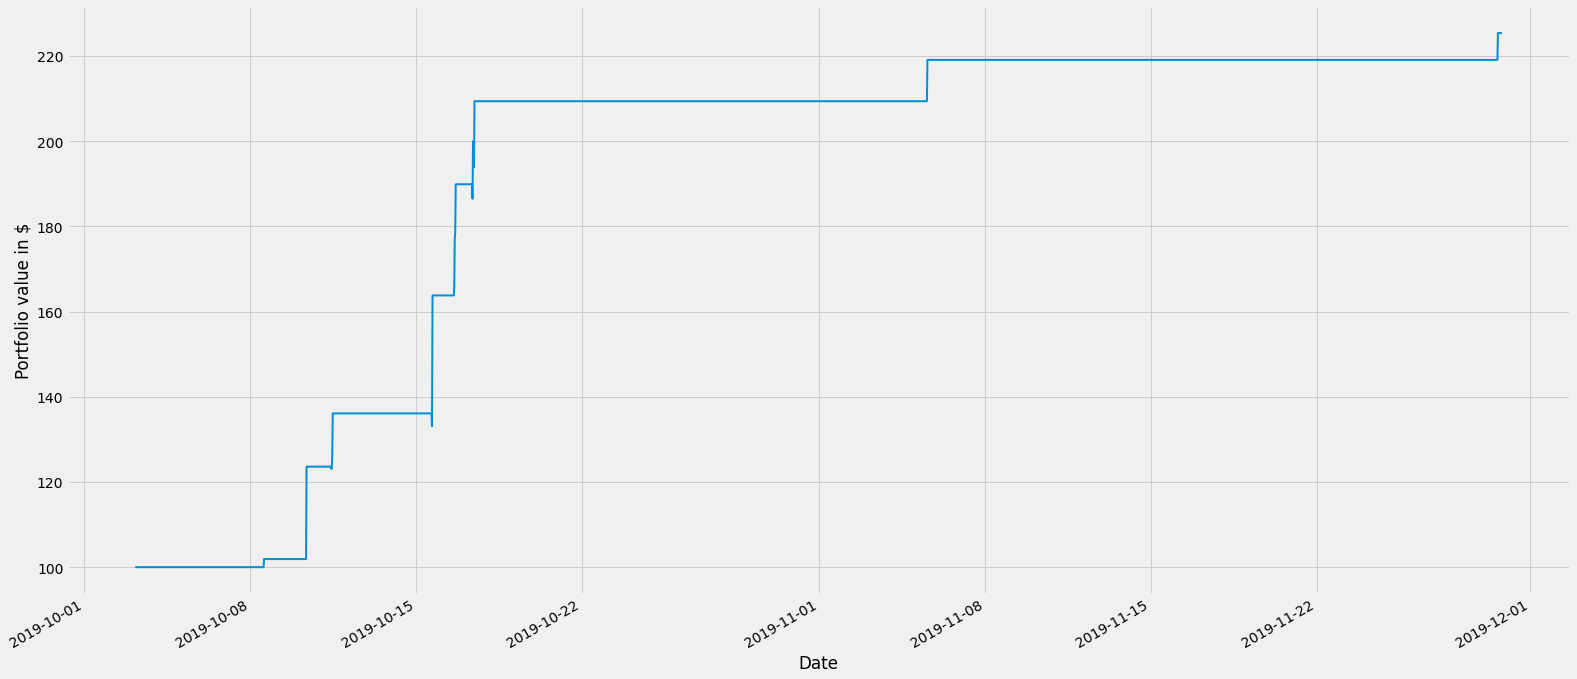

In [92]:
# Set the initial capital
initial_capital= float(100.0)
leverage = 100
# Create a DataFrame `positions`
positions = pd.DataFrame(index=ddf['predicted_signal'].index).fillna(0.0)

# Buy n share
vol = leverage * initial_capital
positions[symbol] = vol*ddf['predicted_signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ddf['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ddf['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ddf['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = round(portfolio['cash'] + portfolio['holdings'], 2)

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio.total.plot(ax=ax1, lw=2.)


# Print the first lines of `portfolio`
print(portfolio.tail())

# Show the plot
plt.show()

#Market Scan and Test

In [93]:
# download the max latest 30mn EURUSD dataframe
import datetime 
import json, urllib.request
api_key = 'd1e61f961d0be9c709b1bd6adaa2cca7'
api_endpoint = 'https://financialmodelingprep.com/api/v3/historical-chart/30min/{symbol}?apikey={key}'
data = urllib.request.urlopen(api_endpoint.format(symbol=symbol.upper(), key=api_key)).read()

In [115]:
target = pd.json_normalize(json.loads(data))
target.columns = pd.Series(target.columns.str.capitalize())
target.index = pd.to_datetime(target['Date'])
target = target[target.index.dayofweek < 5]
target.head()

,Date,Open,Low,High,Close,Volume
Date,,,,,,
2022-01-13 13:00:00,2022-01-13 13:00:00,1.14614,1.1459,1.14664,1.14636,2321
2022-01-13 12:30:00,2022-01-13 12:30:00,1.14612,1.1455,1.14640,1.14607,2151
2022-01-13 12:00:00,2022-01-13 12:00:00,1.14654,1.1454,1.14674,1.14613,2939
2022-01-13 11:30:00,2022-01-13 11:30:00,1.14672,1.1459,1.14710,1.14654,3156
2022-01-13 11:00:00,2022-01-13 11:00:00,1.14602,1.1456,1.14718,1.14673,3877


In [116]:
target = get_macd(target, macd_slow, macd_fast, macd_smooth)
target['rsi'] = get_rsi(target, rsi_period)
target = get_adx(target, period*4)

target['Date'] = pd.to_datetime(target.index)
target['moment'] = target['Date'].dt.dayofweek * 10000  + target['Date'].dt.hour * 60 + target['Date'].dt.minute
target.drop(['Open', 'High', 'Low'], axis=1)
target['tsignal'] = '0'
target['atsignal'] = '0'
target['min_price'] = '0'
target['max_price'] = '0'
target['cci'] = '0'
target['Volume'].replace(0, np.nan, inplace=True)
target.replace([np.inf, -np.inf], np.nan, inplace=True)
target.dropna(inplace=True)
target.head()

,Date,Open,Low,High,Close,Volume,macd8,signal8,hist8,rsi,-DM,+DM,ADX56,moment,tsignal,atsignal,min_price,max_price,cci
Date,,,,,,,,,,,,,,,,,,,
2022-01-13 11:00:00,2022-01-13 11:00:00,1.14602,1.1456,1.14718,1.14673,3877,7.064319e-07,-1.772447e-07,8.836766e-07,72.831783,0.0003,0.00000,15.510881,30660,0,0,0,0,0
2022-01-13 10:30:00,2022-01-13 10:30:00,1.14560,1.1445,1.14613,1.14605,5053,-2.737704e-06,-2.175669e-07,-2.520137e-06,39.223050,0.0011,0.00000,15.510881,30630,0,0,0,0,0
2022-01-13 10:00:00,2022-01-13 10:00:00,1.14735,1.1455,1.14778,1.14558,4079,-1.127112e-05,-3.916386e-07,-1.087948e-05,29.195055,0.0000,0.00165,15.510881,30600,0,0,0,0,0
2022-01-13 09:30:00,2022-01-13 09:30:00,1.14714,1.1468,1.14814,1.14737,4278,2.316363e-07,-3.818232e-07,6.134595e-07,65.437511,0.0000,0.00036,15.510881,30570,0,0,0,0,0
2022-01-13 09:00:00,2022-01-13 09:00:00,1.14715,1.1468,1.14780,1.14713,3942,8.737571e-06,-2.382107e-07,8.975782e-06,60.933948,0.0000,0.00000,15.510881,30540,0,0,0,0,0


# Make prediction using our model

In [112]:
non_features

['Date',
 'tsignal',
 'Close',
 'min_price',
 'max_price',
 'Open',
 'High',
 'Low',
 'atsignal',
 'moment',
 'cci']

In [117]:
non_features
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
ddf = target.drop(non_features, axis=1)
len(ddf)

914

In [118]:
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['Close'] = target['Close']

In [119]:
# reduce data
signals = ddf.loc[(ddf.predicted_signal == 1) | (ddf.predicted_signal ==-1)][:100]
# display the latest signals
signals['TP'] =  signals['Close'] + signals['predicted_signal'] *signals['Close'] * target_rate
signals['SL'] =  signals['Close'] - signals['predicted_signal'] *signals['Close'] * risk
signals.head()

,Volume,macd8,signal8,hist8,rsi,-DM,+DM,ADX56,predicted_signal,Close,TP,SL
Date,,,,,,,,,,,,
2022-01-04 15:00:00,1756,-0.001884,-0.002240,0.000356,39.304994,0.0000,0.00021,11.689593,1,1.12823,1.132273,1.127219
2022-01-04 14:30:00,1887,-0.001885,-0.002235,0.000350,46.618642,0.0000,0.00032,11.706204,1,1.12879,1.132835,1.127779
2022-01-04 13:00:00,1591,-0.001887,-0.002219,0.000331,51.596178,0.0000,0.00023,12.002178,1,1.12918,1.133227,1.128168
2022-01-04 12:30:00,1869,-0.001879,-0.002213,0.000334,53.486386,0.0001,0.00000,12.078198,1,1.12940,1.133448,1.128388
2021-12-20 00:30:00,1706,-0.001256,-0.000836,-0.000420,37.244803,0.0000,0.00000,8.982908,1,1.12542,1.129453,1.124412


In [120]:
# Last prices
target['Close'].head()

Date
2022-01-13 11:00:00    1.14673
2022-01-13 10:30:00    1.14605
2022-01-13 10:00:00    1.14558
2022-01-13 09:30:00    1.14737
2022-01-13 09:00:00    1.14713
Name: Close, dtype: float64

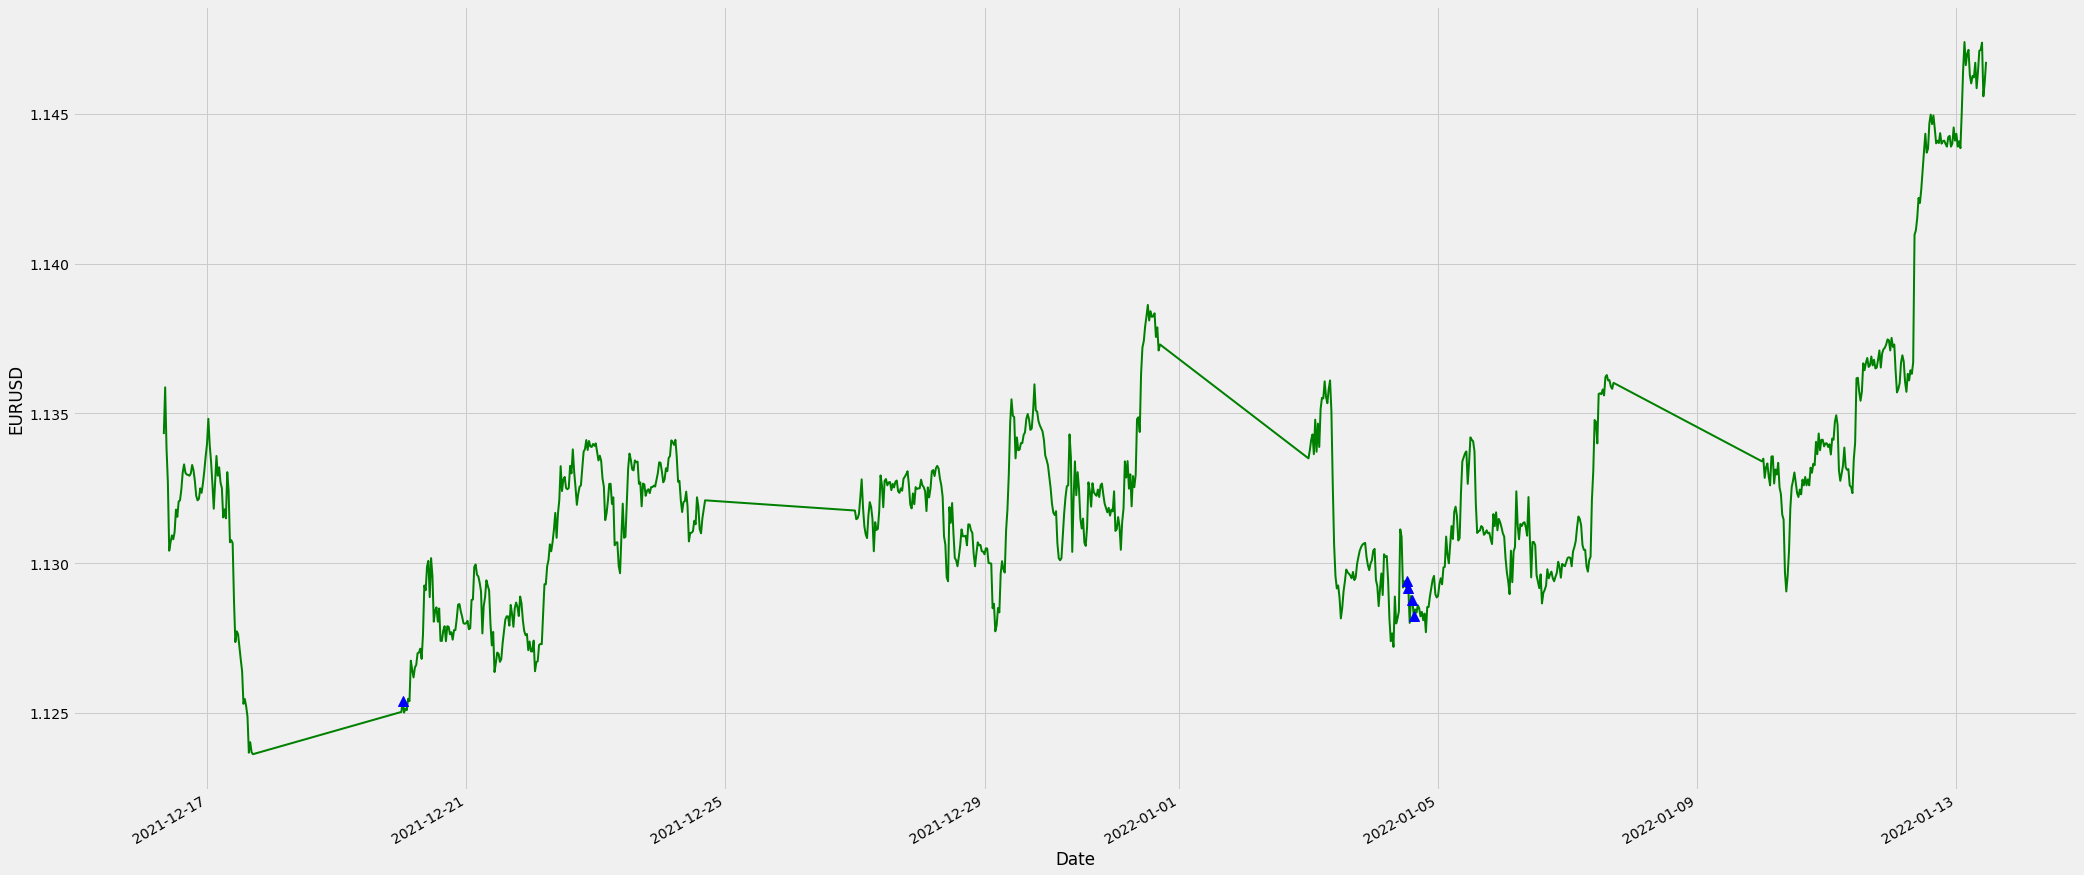

In [121]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel=symbol)

## Plot the closing price
ddf['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(ddf.loc[ddf.predicted_signal == 1.0].index, 
         ddf.Close[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
ax1.plot(ddf.loc[ddf.predicted_signal == -1.0].index, 
         ddf.Close[ddf.predicted_signal == -1.0],
         'v', markersize=10, color='r')

# Show the plot
plt.show()
